# Preparation

In [1]:

import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
def corrfunc(x, y, **kws):
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f"\u03C1 = {r:.2f}\np = {p:.2f}", #unicode code for lowercase rho (ρ)
                xy=(.1, .9), xycoords=ax.transAxes)

# Load C14 models

In [3]:
#import c14_models
import c14
from c14.models import liver as lm

# Read patient data

In [4]:
data = pd.read_csv('../data/C14data_liver_samples_20200330.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
#data = data.query('type == "hepatocyte" and pathology != ["Y","C"]')
# data = data.query('pathology not in ["Y", "C"]')
exp_data = data
len(data)

104

# Plot data 

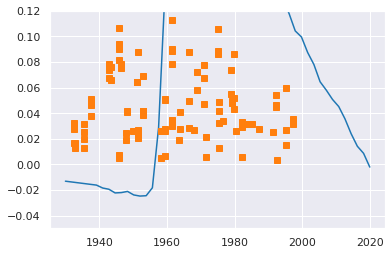

In [5]:
tt = np.linspace(1930, 2020)
Catm = c14.models.base.Catm()
plt.plot(tt, Catm.lin(tt))
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 's')
plt.ylim(-0.05, 0.12)
plt.show()

# Individual rates

In [164]:
#take about 5 hours
ind_rates = []
index =[]
for ind,_ in data.iterrows():
    row = data.loc[[ind]]
    m = lm.POP1()
    edata = c14.exp_data(row)
    op = c14.optimize(m,edata,step_size=0.1)
    for i in  [0.9,-1,-3]:
        resa = sp.optimize.minimize(lambda x: op.Nloglike(x, op.model), [i],method='powell')
        resa['x'] = float(resa['x'])
        ind_rates.append(resa) 
    
    index.append(ind)
individual_rates = pd.DataFrame(ind_rates,index=pd.MultiIndex.from_product([index,['a','b','c']]))

Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
/home/julian/pythonenv/c14/lib/python3.7/site-packages/scipy/optimize/optimize.py:2371: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/julian/uni/c14/c14/c14/optimize.py:150: RuntimeWarning: divide by zero encountered in log
  loglike = -n*0.5*(2.837877066409345 + np.log(sse))
/home/julian/pythonenv/c14/lib/python3.7/site-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/julian/pythonenv/c14/lib/python3.7/site-packages/scipy/optimize/op

Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No 

Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
/home/julian/pythonenv/c14/lib/python3.7/site-packages/scipy/optimize/optimize.py:2672: RuntimeWarning: invalid value encountered in double_scalars
  t *= temp*temp
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default parameters missing sigma added automatikcally with limits 0,0.2
Default logparas missing. 
No linparas -> assuming all are logparas. 
Default linparas missing. Assuming all are logparas
Default

In [10]:
idx = pd.IndexSlice
with pd.HDFStore('ind_rates') as s:
    individual_rates = s['ind'] 
exp_data['individual_rate'] = 10**individual_rates['x'].mean(level=0)

In [23]:

exp_data.to_excel('individual_rate.xlsx')

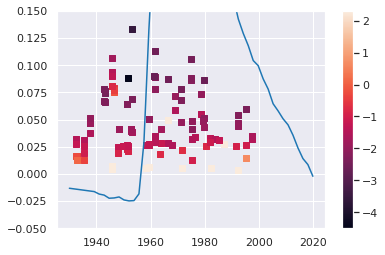

In [11]:
tt = np.linspace(1930, 2020)
plt.plot(tt, Catm.lin(tt))
plt.scatter(exp_data['Dbirth'], exp_data['d14C'], marker='s', c=np.log(exp_data['individual_rate']))
plt.colorbar()
plt.ylim(-0.05, 0.15)
plt.show()

# Plot rates

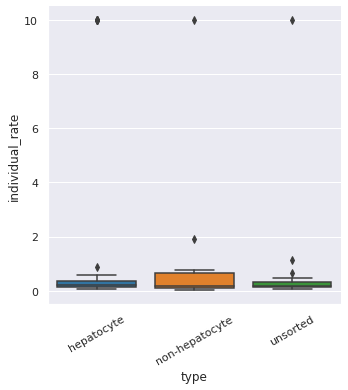

In [13]:
ax = sns.catplot(data=exp_data, x='type', y='individual_rate', kind='box')
ax.set_xticklabels(rotation=30)
plt.show()

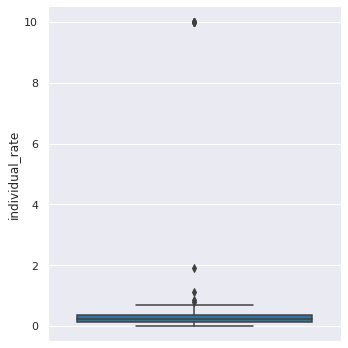

In [14]:
ax = sns.catplot(data=exp_data,  y='individual_rate', kind='box')
plt.show()

# Detect outliers based on IQR

In [16]:
# Computing IQR
Q1 = exp_data['individual_rate'].quantile(0.25)
Q3 = exp_data['individual_rate'].quantile(0.75)
IQR = Q3 - Q1

# Selecting Values between Q1-1.5IQR and Q3+1.5IQR
exp_data['rate_is_not_outlier'] = exp_data.eval('(@Q1 - 1.5 * @IQR) <= individual_rate <= (@Q3 + 1.5 * @IQR)')

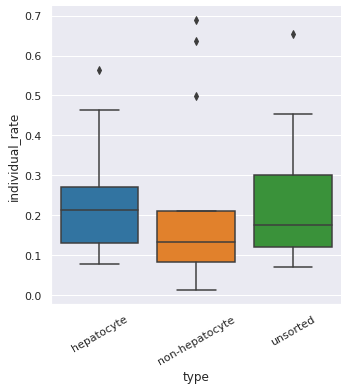

In [17]:
ax = sns.catplot(data=exp_data.query('rate_is_not_outlier'), x='type', y='individual_rate', kind='box')
# sns.swarmplot(data=exp_data, x='type', y='individual_rate_SSE', color='black', size=2)
ax.set_xticklabels(rotation=30)
plt.show()

# Analysing results

I use the values obtained with SSE

In [18]:
exp_data['cell_age'] = 1. / exp_data['individual_rate']

In [19]:
exp_data.head()

,type,sample,ploidy,pathology,Dbirth,Dcoll,d14C,e14C,N_cells,subject_age,age,individual_rate,rate_is_not_outlier,cell_age
0,hepatocyte,HL#11,2n,T,1975.333333,2019.750000,0.012959,0.00640,77.0,44.416667,44.416667,0.371850,True,2.689253
1,hepatocyte,HL#11,4n,T,1975.333333,2019.750000,0.041590,0.00685,12.0,44.416667,44.416667,0.121583,True,8.224822
2,hepatocyte,HL#12,2n4n,T,1947.833333,2017.916667,0.024600,0.00660,59.0,70.083333,70.083333,0.288851,True,3.461993
3,hepatocyte,HL#14,2n4n,T,1943.000000,2018.000000,0.074020,0.01163,54.0,75.000000,75.000000,0.083157,True,12.025389
4,hepatocyte,HL#3,2n4n,C,1951.333333,2017.333333,0.022800,0.00445,96.0,66.000000,66.000000,0.388713,True,2.572591


In [20]:
# exp_data = exp_data[exp_data['ploidy'] == '4n'].query('pathology in ["N", "T"]')

In [21]:
# exp_data

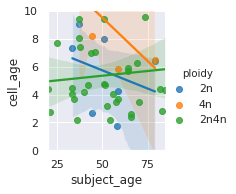

In [22]:
sns.pairplot(exp_data.query('rate_is_not_outlier').query('type == "hepatocyte"'),
            x_vars = ['subject_age'],
            y_vars = ['cell_age'],
             kind='reg',
            hue = 'ploidy')
plt.ylim(0, 10)
plt.show()

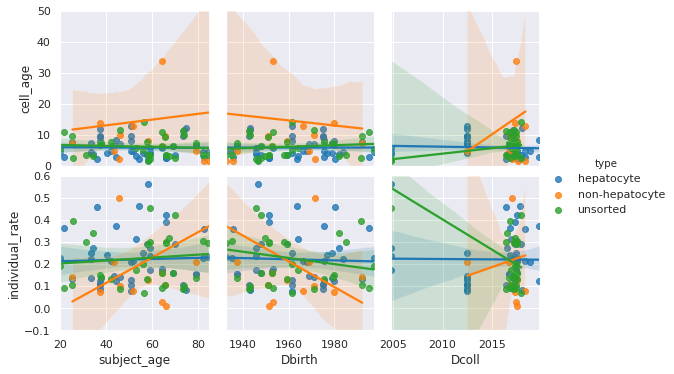

In [24]:
g = sns.pairplot(exp_data.query('rate_is_not_outlier'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age', 'individual_rate'],
             kind='reg',
            hue = 'type')
g.axes[0][0].set_ylim(0, 50)
g.axes[1][0].set_ylim(-0.1, 0.6)
plt.show()